In [1]:
import numpy as np
import pandas as pd
from astropy.io import fits
import os
from astropy.table import Table
from scipy.spatial import KDTree

import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML 

In [2]:
import torch
from torch.utils.data import DataLoader, dataset, TensorDataset
from torch import nn, optim
from torch.optim import lr_scheduler

In [3]:
import sys
sys.path.append('../insight')
from archive import archive 
from insight_arch import Photoz_network
from insight import Insight_module
from utils import sigma68, nmad, plot_photoz_estimates
from scipy import stats

In [4]:
from matplotlib import rcParams
rcParams["mathtext.fontset"] = "stix"
rcParams["font.family"] = "STIXGeneral"
parent_dir = '/data/astro/scratch/lcabayol/Euclid/NNphotozs/Euclid_EXT_MER_PHZ_DC2_v1.5'

In [66]:
photoz_archive = archive(path = parent_dir, Qz_cut=1)
f, ferr, specz, specqz = photoz_archive.get_training_data()

In [67]:
nnz = Photoz_network(num_gauss=6)

In [68]:
insight = Insight_module(nnz, batch_size=100)
insight.train(input_data=f, 
              target_data=specz, 
              nepochs=300, 
              step_size = 150, 
              val_fraction=0.1, 
              lr=1e-3
             )

(-2.0, 0.0)

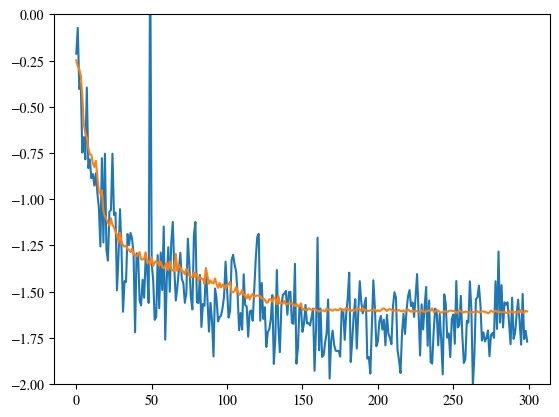

In [69]:
plt.plot(insight.loss_train)
plt.plot(insight.loss_validation)

plt.ylim(-2,0)

In [70]:
f_test, ferr_test, specz_test = photoz_archive.get_testing_data()

In [71]:
z,zerr = insight.get_photoz(input_data=torch.Tensor(f_test), target_data=torch.Tensor(specz_test))

Text(0, 0.5, '$z$')

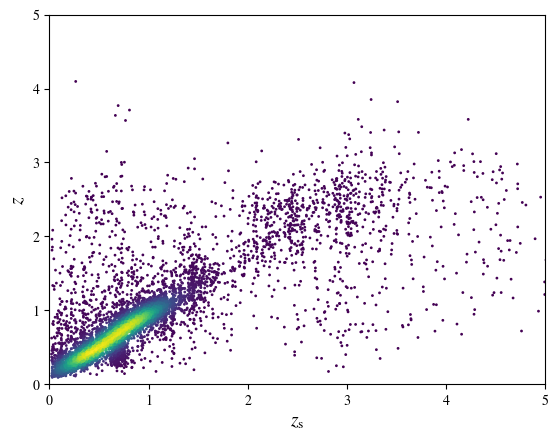

In [72]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([specz_test,z])
zd = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
plt.scatter(specz_test, z,c=zd, s=1)
plt.xlim(0,5)
plt.ylim(0,5)

plt.xlabel(r'$z_{\rm s}$', fontsize = 14)
plt.ylabel('$z$', fontsize = 14)

Text(0, 0.5, '$z$')

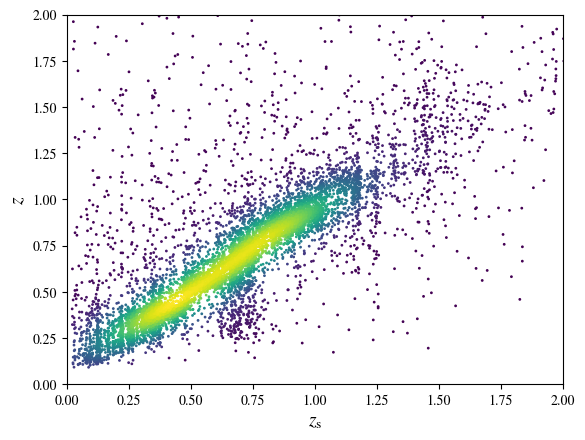

In [73]:
from scipy.stats import gaussian_kde

# Calculate the point density
xy = np.vstack([specz_test,z])
#zd = gaussian_kde(xy)(xy)

fig, ax = plt.subplots()
plt.scatter(specz_test, z,c=zd, s=1)
plt.xlim(0,2)
plt.ylim(0,2)

plt.xlabel(r'$z_{\rm s}$', fontsize = 14)
plt.ylabel('$z$', fontsize = 14)

In [74]:
VISmag = photoz_archive.get_VIS_mag(photoz_archive.cat_test)

In [55]:
df_test = pd.DataFrame(np.c_[VISmag, specz_test,z,zerr], columns = ['VISmag','zs','z','zuncert'])
df_test['zwerr'] = (df_test.z -df_test.zs) / (1+df_test.zs)

In [56]:
df_test = df_test[df_test.VISmag<25]
df_test = df_test[df_test.z<4]

In [57]:
def plot_photoz(df, nbins,xvariable,metric, type_bin='bin'):
    bin_edges = stats.mstats.mquantiles(df[xvariable].values, np.linspace(0.01,1,nbins))
    ydata,xdata = [],[]
    
    
    for k in range(len(bin_edges)-1):
        edge_min = bin_edges[k]
        edge_max = bin_edges[k+1]

        mean_mag =  (edge_max + edge_min) / 2
        
        if type_bin=='bin':
            df_plot = df_test[(df_test[xvariable] > edge_min) & (df_test[xvariable] < edge_max)]
        elif type_bin=='cum':
            df_plot = df_test[(df_test[xvariable] < edge_max)]
        else:
            raise ValueError("Only type_bin=='bin' for binned and 'cum' for cumulative are supported")


        xdata.append(mean_mag)
        if metric=='sig68':
            ydata.append(sigma68(df_plot.zwerr))
            ylab=r'$\sigma_{\rm NMAD} [\Delta z]$'
        elif metric=='bias':
            ydata.append(np.median(df_plot.zwerr))
            

            ylab=r'Median $[\Delta z\ /\ (1 + z)]$'
        elif metric=='nmad':
            ydata.append(nmad(df_plot.zwerr))
            ylab=r'$\sigma_{\rm NMAD} [\Delta z]$'
            plt.axhline(y=0.05, ls='--', color ='black')
        elif metric=='outliers':
            ydata.append(len(df_plot[np.abs(df_plot.zwerr)>0.15])/len(df_test) *100)
            ylab=r'$\eta$ [%]'
            
    if xvariable=='VISmag':
        xlab='VIS'
    elif xvariable=='zs':
        xlab=r'$z_{\rm spec}$'
    elif xvariable=='z':
        xlab=r'$z$'

    plt.plot(xdata,ydata, ls = '-', marker = '.', color = 'crimson',lw = 1, label = '')
    
    if metric=='bias':
        plt.fill_between(xdata, y1=-0.002, y2=0.002, color ='grey', alpha=0.5)
    plt.ylabel(f'{ylab}', fontsize = 18)
    plt.xlabel(f'{xlab}', fontsize = 16)

    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)

    plt.grid(False)
    
    plt.show()
   

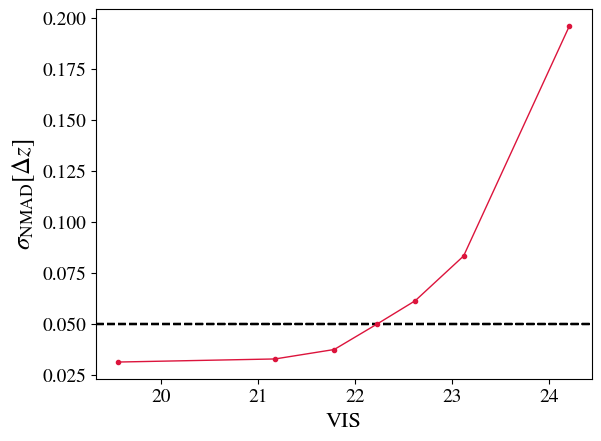

In [58]:
plot_photoz(df_test, 8,'VISmag','nmad', type_bin='bin')

In [59]:
nmad(df_test[df_test.VISmag<25].zwerr)

0.05516990531521328

In [60]:
df_test = df_test[df_test.VISmag<25]

In [61]:
len(df_test[np.abs(df_test.zwerr)>0.15])/len(df_test)

0.15095689500983725

In [19]:
torch.save(insight.model.state_dict(),'/data/astro/scratch/lcabayol/Euclid/NNphotozs/models/insight_v1.pt')
           


In [62]:
df_test.to_csv('/data/astro/scratch/lcabayol/Euclid/NNphotozs/results/df2.csv', sep=',')

In [63]:
# Create a list of additional header lines
header_lines = [
    "# Training spect-zs with a strict quality cut",
    "#2 MDN components",
    "#Gaussian loss function",
    "# For 300 epochs with lr0=1e-3 + 150 epochs with lr=1e-4",
    "# Date: 2023-10-05",
]

# Write DataFrame to a CSV file with custom header lines
with open('/data/astro/scratch/lcabayol/Euclid/NNphotozs/results/df2.csv', 'w') as f:
    for line in header_lines:
        f.write(line + '\n')
    df_test.to_csv(f, header=True, index=False, line_terminator='\n')


In [25]:
df_test

,VISmag,zs,z,zuncert,zwerr
0,23.103798,1.103000,1.141306,0.083867,0.018215
1,22.471019,0.468800,0.441243,0.048078,-0.018761
2,21.853940,0.694600,0.673715,0.093922,-0.012324
3,22.005561,0.649200,0.570653,0.185431,-0.047628
4,22.204387,0.666900,0.641867,0.096566,-0.015018
...,...,...,...,...,...
11509,22.449399,0.690462,0.664242,0.045307,-0.015510
11510,22.102501,0.915746,0.976074,0.098013,0.031491
11511,22.982543,0.721060,0.744999,0.080026,0.013909
11512,20.037661,0.345100,0.365166,0.039481,0.014918
